In [1]:
import os
import numpy as np
from scipy import ndimage as ndi
from scipy.stats import poisson
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

from analyfits import misc
from analyfits.manipufits import ManipulateFits
from analyfits import datafits

In [2]:
# Cargo una lista con los directorios de todas las imágenes.
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K"
#DIR_win = "D:\ignag\Igna\Facultad\Tesis2021\Archivos\T123K"
os.chdir(DIR)
fits_imgs_list = misc.fits_finder(DIR)

# Prueba de Concepto

### Pasos
- 1) Tomar una imagen en unidades de electrones ```img_original```
- 2) Separarla en dos imágenes, una con eventos de 1 e y otra con los restantes: ```img_clusters```
- 3) Tomo la imagen con eventos de 2 o más electrones y la dilato 2 veces para crear la máscara ```mask```
- 4) Uso la máscara para, en la imagen original (```img_original```), hacer 0 los valores que corresponden (donde la máscara es ```True```)
- 5) Calculo la relación entre cantidad de píxeles con eventos de 1 electrón vs píxeles vacíos.
    - 5)a) ¿Píxeles no ocupados por la máscara? <- esta voy a hacer yo porque tiene más sentido.
    - 5)b) ¿Píxeles no ocupados totales?

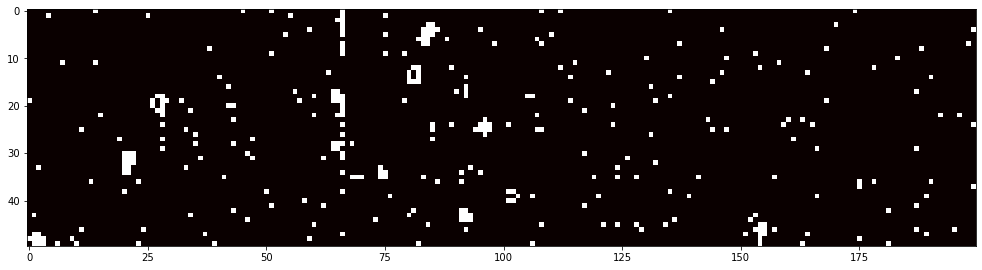

In [3]:
# agarro una imagen random
import random
img_dir = random.choice(fits_imgs_list)

# 1)
# Abro la imagen orignal (completa en electrones)
fits_image = ManipulateFits()
img_original = fits_image.ADU2e(img_dir)

# 2)
# La transformo a matriz numpy y la separo en 2
img_clusters = fits_image.single_fits2double_fits(img_dir)[1]

# Imagen con clusters
plt.figure(figsize=(17,9))
plt.imshow(img_clusters[0:50, 100:300], cmap="hot", vmin=0, vmax=2)

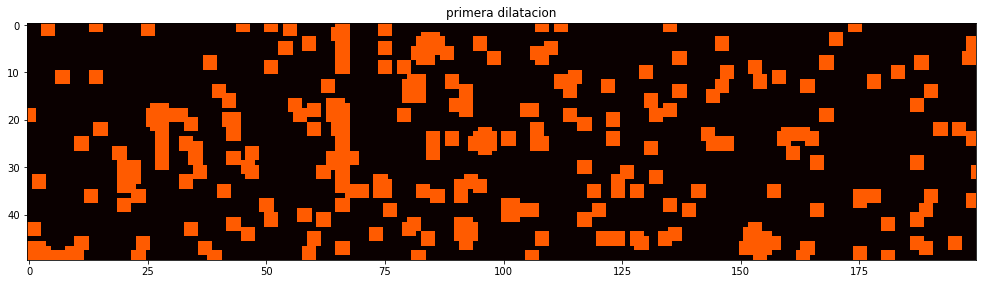

In [4]:
struct = [[1,1,1],
          [1,1,1],
          [1,1,1]]

# 3)
# Imagen dilatada 1 vez
img_dilat = ndi.morphology.binary_dilation(img_clusters, structure=struct)
plt.figure(figsize=(17,9))
plt.title("primera dilatacion")
plt.imshow(img_dilat[0:50, 100:300], cmap="hot", vmin=0, vmax=2)

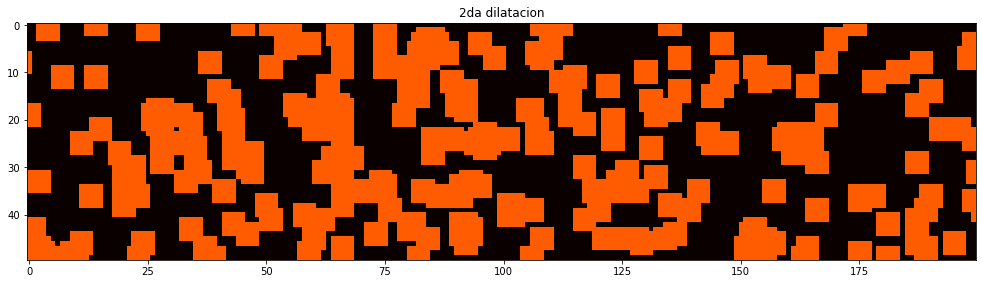

In [5]:
# 3)
# Imagen dilatada 2 veces: Máscara
mask = ndi.morphology.binary_dilation(img_dilat, structure=struct)
plt.figure(figsize=(17,9))
plt.title("2da dilatacion")
plt.imshow(mask[0:50, 100:300], cmap="hot", vmin=0, vmax=2)

### Ahora uso la máscara para eliminar de la imagen original todos los eventos de 2 o más electrones, y quedarme solo con los de 1 electrón alejados

In [6]:
# 4)
clean_image = np.where(mask==True, 0, img_original)

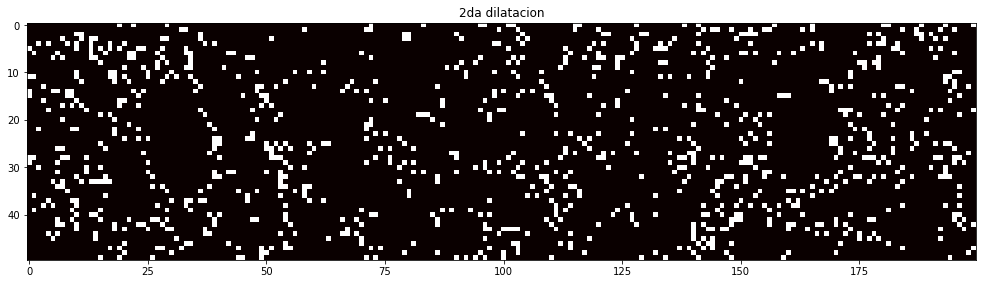

In [7]:
plt.figure(figsize=(17,9))
plt.title("2da dilatacion")
plt.imshow(clean_image[0:50, 100:300]*10, cmap="hot", vmin=0, vmax=2)

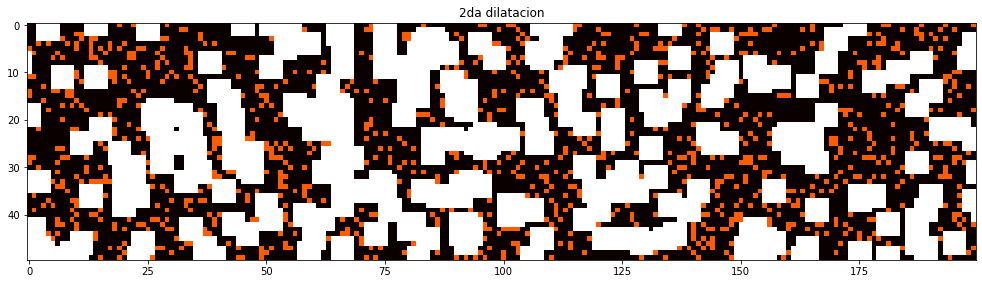

In [8]:
plt.figure(figsize=(17,9))
plt.title("2da dilatacion")
plt.imshow((mask*20 + clean_image)[0:50, 100:300]*10, cmap="hot", vmin=0, vmax=20)

In [9]:
ones = clean_image[clean_image==1].size
zeros = clean_image[clean_image==0].size - mask[mask==True].size
rate = ones/zeros
rate

0.1736573892591141

Para todas las imágenes:

In [10]:
zeros = 0
ones = 0
for i, img in enumerate(fits_imgs_list):
    # Original
    fits_image = ManipulateFits()
    img_original = fits_image.ADU2e(img)[:, 8:451]
    # 2 o más eventos
    img_clusters = fits_image.single_fits2double_fits(img)[1][:, 8:451]
    # Estructura
    struct = [[1,1,1],
              [1,1,1],
              [1,1,1]]
    
    # Máscara (dilato 2 veces)
    mask = ndi.morphology.binary_dilation(img_clusters, structure=struct, iterations=2)
    # Resta: Donde está la mascara, elimino eventos en la imagen original
    img_clean = np.where(mask==True, 0, img_original)
    # Acumulo
    zeros += img_clean[img_clean==0].size - mask[mask==True].size
    ones += img_clean[img_clean==1].size
    porcentaje = (i+1)*100/len(fits_imgs_list)
    print(f"\rCompletado {porcentaje:.2f}%",end= "")

Completado 100.00%

In [11]:
mu_bkg = ones/zeros
mu_g = 0.2245 - mu_bkg
error_bkg = np.sqrt((1/np.sqrt(ones))**2 + (1/np.sqrt(zeros))**2)*(ones/zeros)
print(f"µ_bkg es: µ_bkg = {mu_bkg:.5f} +/- {error_bkg:.5f}")

µ_bkg es: µ_bkg = 0.21505 +/- 0.00017


In [12]:
ones

1879896

### El $\mu_{bkg} = 0.21505 \pm 0.00017$ y tiene sentido que ande cerca del $\mu_{T} = 0.2245 \pm 0.0001$, porque la mayoría de los eventos de $1\,e^{-}$ deben venir de corrientes oscuras.

La pregunta ahora es:
- Si $\mu_{T} = 0.2245 \pm 0.0001$
- y $\mu_{bkg} = 0.21505 \pm 0.00017$
- ¿Entonces $\mu_{g} = \mu_{T} - \mu_{bkg}$?

En ese caso entonces

\begin{equation}
    \mu_{g} = 0.0094 \pm 0.0001
\end{equation}

## Análisis de bordes

En base a estos valores de $\mu_{bkg}$ y $\mu_{g}$ a ver cuántos eventos esperaría en cada caso en los bordes

In [13]:
# probabilidad de tener un electrón real en un pixel
real_p = poisson.pmf(mu=mu_g, k=1)
# probabilidad de tener un electrón de background en un pixel
bkg_p = poisson.pmf(mu=mu_bkg, k=1)
# acumuladores: Carga real, background y medida
real_border_charge = 0
bkg_border_charge = 0
measured_border_charge = 0
for i, image in enumerate(fits_imgs_list):
    charge, pixels, n_clusters = datafits.border_events(image, low_th=2)
    real_border_charge += pixels * real_p
    bkg_border_charge += pixels * bkg_p
    measured_border_charge += charge
    percentage = (i + 1) * 100 / len(fits_imgs_list)
    print(f"\rCompletado {percentage:.2f}%",end= "")

Completado 100.00%

In [14]:
print(f"Carga real esperada: {real_border_charge:.2f}")
print(f"Carga espuria esperada: {bkg_border_charge:.2f}")
print(f"Carga medida: {measured_border_charge:.2f} ")

Carga real esperada: 314.69
Carga espuria esperada: 5832.27
Carga medida: 6538.00 


Entonces a la carga de 6538 eventos de un electrón en los bordes de todos los clusters de todas las imágenes, con estos valores de $\mu_{bkg}$ habría que restarle 5832 eventos para quedarse solo con los reales.

## Análisis de clusters

In [15]:
# datos de las imagenes originales
lista_dics, lista_img_idx = datafits.image2cluster_info(fits_imgs_list,
                                                        img="o",
                                                        upp_th=None)

100.00%

In [16]:
# Armo el dataframe
df = datafits.df_gen(lista_dics, lista_img_idx)

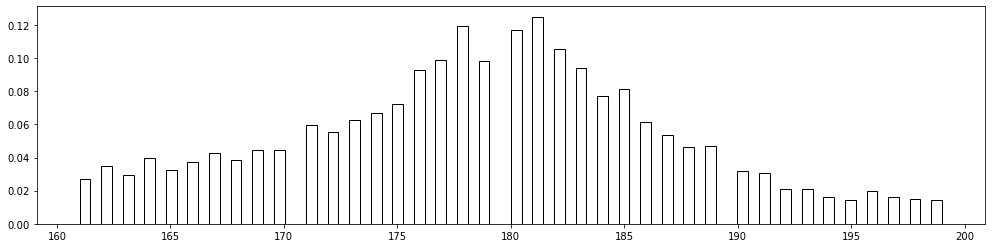

In [17]:
fluor = df[(df["energia"]>160) &  (df["energia"]<200)].copy()
plt.figure(figsize=(17,4))
plt.hist(fluor["energia"], bins=80, fill=False, density=True);

Voy a tomar los eventos entre 160 y 220 y, sabiendo la cantidad de eventos espurios en la superficie del clúster van como $N\mu_{bkg}$ (donde $N$ es la cantidad de píxeles del clúster), calculo cuántos eventos tengo que sacar para tener el número real de estos

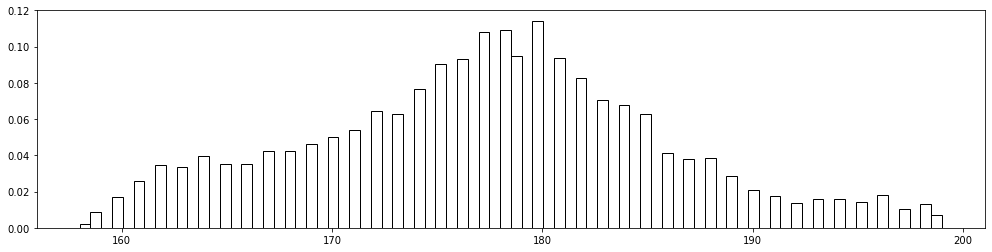

In [18]:
fluor["espurios"] = round(fluor["area"]*mu_bkg)
fluor["energia_corregida"] = fluor["energia"] - fluor["espurios"]
plt.figure(figsize=(17,4))
plt.hist(fluor["energia_corregida"], bins=80, fill=False, density=True);

In [19]:
mean_energia = fluor["energia_corregida"].mean()
std_energia = fluor["energia_corregida"].std()
fano = std_energia**2/mean_energia
fano

0.39847840276705865

In [20]:
mean_energia = fluor["energia"].mean()
std_energia = fluor["energia"].std()
fano = std_energia**2/mean_energia
fano

0.39292322496471466

# Modificaciones al cálculo de $\mu_{bkg}$

### Calcular el $\mu_{T}$ SOLO EN LAS POLLERAS. Es decir, tomo una imagen de 2 o más eventos, la dilato una vez y me quedo SOLO CON LA PARTE DILATADA. A esa le cuento  cuántos eventos de 1 e tengo y calculo el $\mu_{T}$. Eso es $\mu_{T}$ right now.

Después a eso le resto el $\mu_{bkg}$

Prueba de concepto de esto de acá arriba (análisis final) para el cálculo de $\mu_{T}$

In [21]:
# tomo una imagen random
img = random.choice(fits_imgs_list)

In [22]:
# La escribo en unidades de electrones
fits_image = ManipulateFits()
img_e = fits_image.ADU2e(img)[:, 8:451]

In [23]:
# Ahora me quedo con la imagen con 2 o más electrones
img_2omas = fits_image.single_fits2double_fits(img)[1][:, 8:451]

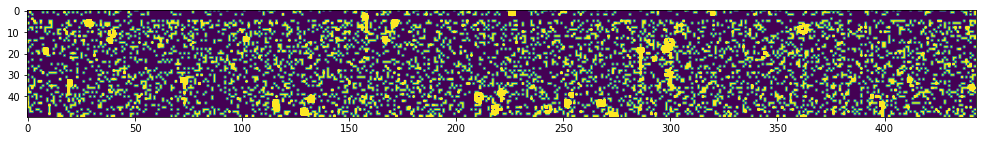

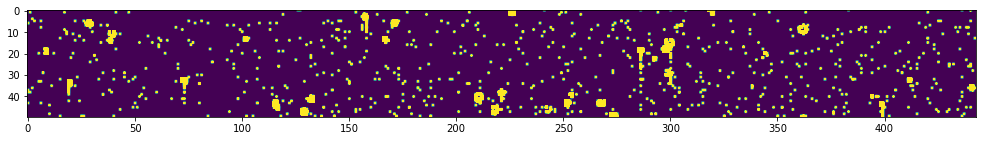

In [24]:
# Grafico imagen completa y 2 o más electrones
plt.figure(figsize=(17,2))
plt.imshow(img_e, vmin=0, vmax=1)
plt.figure(figsize=(17,2))
plt.imshow(img_2omas, vmin=0, vmax=1)

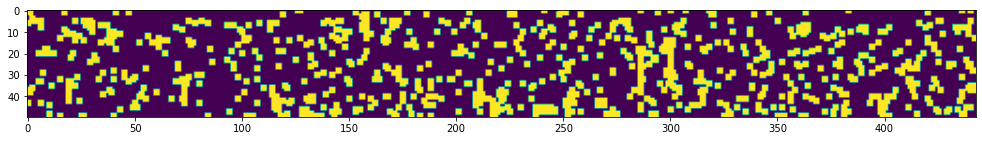

In [25]:
# dilato la imagen una vez con 
# Estructura
struct = [[1,1,1],
          [1,1,1],
          [1,1,1]]
    
# Máscara (dilato 1 vez)
mask = ndi.morphology.binary_dilation(img_2omas, structure=struct)
plt.figure(figsize=(17,2))
plt.imshow(mask, vmin=0, vmax=1)

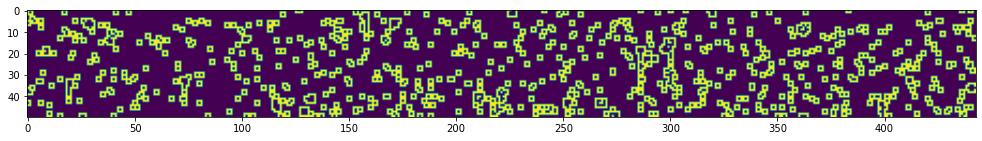

In [26]:
# Le resto a la máscara los pixeles donde estaba los eventos de 2 o más
mask = np.where(img_2omas!=0, 0, mask)
plt.figure(figsize=(17,2))
plt.imshow(mask, vmin=0, vmax=1)

Ahora, con esta máscara, usando solo la parte de la imagen donde hay datos voy a contar cuántos eventos de 1e caen dentro de estos valores (usando la imagen completa original)

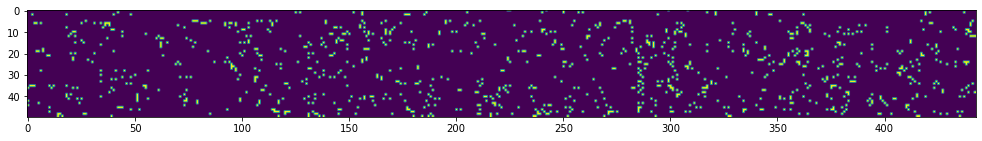

In [27]:
# cuento eventos de un electrón solo en la máscara
img_1e = np.where(mask!=0, img_e, 0)
plt.figure(figsize=(17,2))
plt.imshow(img_1e, vmin=0, vmax=1)
# descomentar para constatar que las que sobreviven caen sobre las polleras
#plt.figure(figsize=(17,2))
#plt.imshow((img_1e*2 + mask), vmin=0, vmax=2)

In [28]:
# Voy a contar el área total que ocupan las polleras y el area que ocupan los eventos de 1e sobre esa área total
total_border_area = np.sum(mask)
total_single_event_area = np.sum(img_1e)

Entonces, el $\mu_{T}$ va a tener que ser ```total_single_event_area/total_border_area```

In [29]:
mu_T = total_single_event_area / total_border_area
print(f"el µ_T = {mu_T}")

el µ_T = 0.20417910447761195


Ahora hago este análisis para todas las imágenes

In [30]:
ones = 0
zeros = 0
for i, img in enumerate(fits_imgs_list):
    # Original
    fits_image = ManipulateFits()
    img_original = fits_image.ADU2e(img)[:, 8:451]
    # 2 o más eventos
    img_clusters = fits_image.single_fits2double_fits(img)[1][:, 8:451]
    # Estructura
    struct = [[1,1,1],
              [1,1,1],
              [1,1,1]]
    
    # Máscara (dilato 1 vez)
    mask = ndi.morphology.binary_dilation(img_clusters, structure=struct)
    # Resta: A la máscara le saco los pixeles donde hay eventos de 2 o más
    mask = np.where(img_clusters!=0, 0, mask)
    # A la imagen original le saco todos los eventos menos los que cayeron en la mask
    img_1e = np.where(mask!=0, img_original, 0)
    # acumulo
    ones += img_1e[img_1e!=0].size
    zeros += np.sum(mask)
    porcentaje = (i+1)*100/len(fits_imgs_list)
    print(f"\rCompletado {porcentaje:.2f}%",end= "")
mu_T, error_mu_T = ones/zeros, np.sqrt((1/np.sqrt(ones))**2 + (1/np.sqrt(zeros))**2)*(ones/zeros)

Completado 100.00%

## ¿Por qué ahora el $\mu_{T}$ lo calculo solo mirando las polleras?
Porque considerando que $\mu_{T} = \mu_{bkg} + \mu_{g}$, el $\mu_{g}$ solo existe en las polleras. Es decir, cuando aplico el corte de calidad con epix = 1.5, estoy tirando todos los eventos de 1 electrón y eso podría llevar a que tire eventos reales de un cluster en el borde que tienen 1 electrón. Entonces voy a considerar que los eventos genuinos de un electrón solo pueden estar en las polleras. Pero además de eventos reales, en las polleras también hay backgroud, obviamente. Hasta acá tiene sentido pero, de nuevo, ¿Por qué calculo el $\mu_{T}$ solo en las polleras? Porque dado que los eventos genuinos considero que solo están en las polleras, calcular el $\mu_{T}$ en los eventos de 1 electrón en **todo** el sensor agregaría un sesgo debido a que estoy mirando regiones donde **sé** que no hay eventos genuinos.
Entonces, como seguro hay eventos genuinos y de background en polleras, puedo calcular el $\mu_{T}$ ahí y usar el $\mu_{bkg}$ calculado en todo el sensor para hallar el $\mu_{g}$

El problema ahora es que el $\mu_{T}$ está dando menor que el $\mu_{bkg}$

### Si $\mu_{T}$ es menor que $\mu_{bkg}$ tengo una incompatibilidad porque $\mu_{T} = \mu_{bkg} + \mu_{g}$. Entonces la solución es que en vez de considerar el $\mu_{bkg}$ en todo el sensor, que el problema que tiene es que asumo que el background es uniforme en toda el área activa, lo que hago es mirar una dilatación más de los bordes de los clústers de 2 o más electrones.

Entonces, repito el análisis que hice para calcular el nuevo $\mu_{T}$, pero en vez de dilatar 1 vez, dilato 2 veces y me quedo solamente con el 2do borde dilatado y los eventos de 1e que caen en él. Calculo la relación entre esos eventos y la cantidad total de píxeles de esas áreas.

Por otro lado tiene más sentido mirar píxeles cercanos a los eventos de 2 electrones que mirar todo el sensor.


In [31]:
ones = 0
zeros = 0
for i, img in enumerate(fits_imgs_list):
    # Original
    fits_image = ManipulateFits()
    img_original = fits_image.ADU2e(img)[:, 8:451]
    # 2 o más eventos
    img_clusters = fits_image.single_fits2double_fits(img)[1][:, 8:451]
    # Estructura
    struct = [[1,1,1],
              [1,1,1],
              [1,1,1]]
    
    # Máscara1 (dilato 1 vez)
    mask_1 = ndi.morphology.binary_dilation(img_clusters, structure=struct)
    # máscara2 (dilato 1 vez mask_1)
    mask_2 = ndi.morphology.binary_dilation(mask_1, structure=struct)
    # Resta: A la máscara2 le saco los pixeles de mask_1
    mask_2 = np.where(mask_1!=0, 0, mask_2)
    # A la imagen original le saco todos los eventos menos los que cayeron en la mask
    img_1e = np.where(mask_2!=0, img_original, 0)
    # acumulo
    ones += img_1e[img_1e!=0].size
    zeros += np.sum(mask_2)
    porcentaje = (i+1)*100/len(fits_imgs_list)
    print(f"\rCompletado {porcentaje:.2f}%",end= "")
mu_bkg, error_mu_bkg = ones/zeros, np.sqrt((1/np.sqrt(ones))**2 + (1/np.sqrt(zeros))**2)*(ones/zeros)

Completado 100.00%

In [32]:
mu_g = mu_T - mu_bkg
error_mu_g = error_mu_T - error_mu_bkg

In [33]:
print(f"mu_T = {mu_T:.10f} +/- {error_mu_T:.10f}")
print(f"mu_bkg = {mu_bkg:.10f} +/- {error_mu_bkg:.10f}")
print(f"mu_g = {mu_g:.10f} +/- {error_mu_g:.10f}")

mu_T = 0.1973534613 +/- 0.0002454066
mu_bkg = 0.1858292312 +/- 0.0002068989
mu_g = 0.0115242301 +/- 0.0000385077


Ahora, ya tengo todos los $\mu$ que necesito. Lo próximo es buscar de nuevo clústers de 2 o más electrones (epix = 1.5 == lower_thresh = 2), calcular su área (número total de píxeles), su carga y calcular cuánta carga se espera que sea espuria en su superficie (hay que restársela) y cuánta carga se estima que le saqué al aplicar epix = 1.5 en los bordes y agregársela.

In [34]:
lista_dics, lista_img_idx = datafits.image2cluster_info(fits_imgs_list,
                                                        img="o",
                                                        upp_th=None)
df = datafits.df_gen(lista_dics, lista_img_idx)

100.00%

Ahora puedo agregar 2 columnas nuevas: Una para la cantidad de eventos de background esperados en superficie y otra para la cantidad de eventos de borde esperados que se perdieron por el lower_threshold (epix = 1.5)

In [35]:
df["expected_superficial_noise"] = mu_bkg*df["area"]
df["expected_border_events_lost"] = mu_g*df["area"] 

In [36]:
df

,img_idx,energia,area,centro,perimetro,expected_superficial_noise,expected_border_events_lost
0,0.0,2.0,1,"(1.0, 434.0)",0.000000,0.185829,0.011524
1,0.0,4.0,2,"(13.0, 68.5)",0.000000,0.371658,0.023048
2,0.0,29.0,8,"(16.0, 276.5)",6.000000,1.486634,0.092194
3,0.0,6.0,3,"(18.666666666666668, 144.66666666666666)",3.414214,0.557488,0.034573
4,0.0,27.0,3,"(19.666666666666668, 327.6666666666667)",3.414214,0.557488,0.034573
...,...,...,...,...,...,...,...
503988,924.0,2.0,1,"(49.0, 289.0)",0.000000,0.185829,0.011524
503989,924.0,2.0,1,"(49.0, 357.0)",0.000000,0.185829,0.011524
503990,924.0,4.0,2,"(49.0, 359.5)",0.000000,0.371658,0.023048
503991,924.0,5.0,1,"(49.0, 419.0)",0.000000,0.185829,0.011524


y por último, el valor que todos estabamos esperando, una columna para la energia corregida por estos sesgos. 

Me queda la duda de como redondear esta corrección, si para arriba o para abajo.

In [37]:
df["corrected_energy"] = df.energia + df.expected_border_events_lost - df.expected_superficial_noise

Casteo a integers los índices de las imágenes y la carga

In [38]:
df[["img_idx", "energia", "corrected_energy"]] = df[["img_idx", "energia", "corrected_energy"]].astype("int32")

Armo un dataframe solo con la data que me interesa

In [39]:
energy = df[["img_idx", "corrected_energy", "energia"]].copy()

In [40]:
energy[(energy["energia"]>160) & (energy["energia"]<200)]

,img_idx,corrected_energy,energia
72,1,186,188
200,1,190,192
399,1,175,177
655,1,179,181
832,1,177,179
...,...,...,...
503368,923,183,184
503371,923,186,188
503569,924,173,175
503603,924,166,168


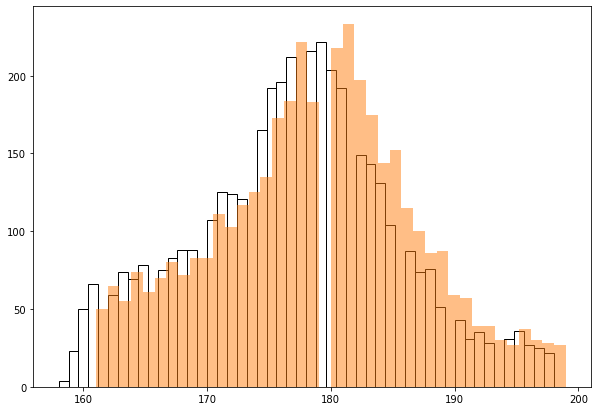

In [41]:
plt.figure(figsize=(10,7))
plt.hist(_["corrected_energy"], bins=50, fill=False);
plt.hist(_["energia"], bins=40, alpha=.5);

In [42]:
energia_corregida = energy[(energy["corrected_energy"]>160) & (energy["corrected_energy"]<200)]["corrected_energy"].values

In [43]:
mean_e = energia_corregida.mean()
std_e = energia_corregida.std()

In [44]:
F = std_e**2/mean_e
F

0.3874782762174957

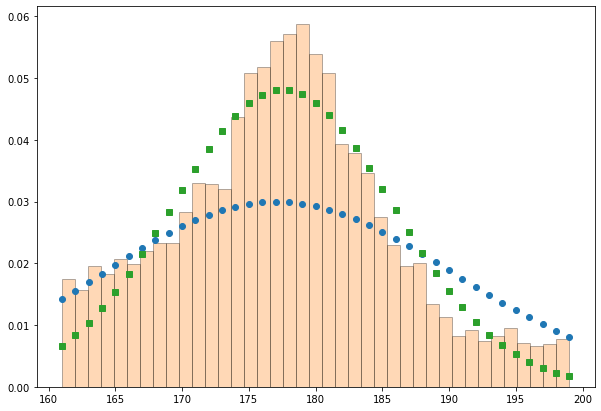

In [45]:
plt.figure(figsize=(10,7))
X = energia_corregida.copy()
X.sort()
X = np.array(list(set(X)))
# Poisson teorica
plt.plot(X, poisson.pmf(mu=mean_e, k=X),'o')
# histograma de datos corregidos
plt.hist(energia_corregida, bins=39, alpha=.3, edgecolor="k", density=True);
# Gaussiana con mu y sigma dados
plt.plot(X, norm.pdf(X, mean_e, std_e), "s")